In [94]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/apple-quality/apple_quality.csv


# Import Libraries

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sb

from scipy import stats
from colorama import Fore, init
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore")


# **1. Data Import**

# 1.1 Data Structure

In [96]:
df = pd.read_csv("/kaggle/input/apple-quality/apple_quality.csv")

In [97]:
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4001 entries, 0 to 4000
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   A_id         4000 non-null   float64
 1   Size         4000 non-null   float64
 2   Weight       4000 non-null   float64
 3   Sweetness    4000 non-null   float64
 4   Crunchiness  4000 non-null   float64
 5   Juiciness    4000 non-null   float64
 6   Ripeness     4000 non-null   float64
 7   Acidity      4001 non-null   object 
 8   Quality      4000 non-null   object 
dtypes: float64(7), object(2)
memory usage: 281.4+ KB


In [99]:
df.describe()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277
std,1154.844867,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427
min,0.000000,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212
max,3999.000000,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837


In [100]:
df[df.isnull().any(axis=1)]

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


In [101]:
df.isnull().sum()

A_id           1
Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
Acidity        0
Quality        1
dtype: int64

# 1-2. Data processing

In [102]:
def data_processing(df):
    df = df.drop(columns = ['A_id'])
    df = df.dropna()
    df = df.astype({'Acidity':'float64'})

    def labeling(Quality):
        if Quality == "good":
            return 1
        else :
            return 0
        
        return None
    
    df['Label'] = df['Quality'].apply(labeling)
    df = df.drop(columns = ['Quality'])
    df = df.astype({'Label':'int64'})
    
    return df

df_train = data_processing(df.copy())
df_train.head()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Label
0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590,1
1,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809,1
2,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636,0
3,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723,1
4,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984,1


**Trasform 'Quality' to 0 or 1**

In [103]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Size         4000 non-null   float64
 1   Weight       4000 non-null   float64
 2   Sweetness    4000 non-null   float64
 3   Crunchiness  4000 non-null   float64
 4   Juiciness    4000 non-null   float64
 5   Ripeness     4000 non-null   float64
 6   Acidity      4000 non-null   float64
 7   Label        4000 non-null   int64  
dtypes: float64(7), int64(1)
memory usage: 281.2 KB


# 1-3. Data Visualization

**Ratio of 'Quality'**

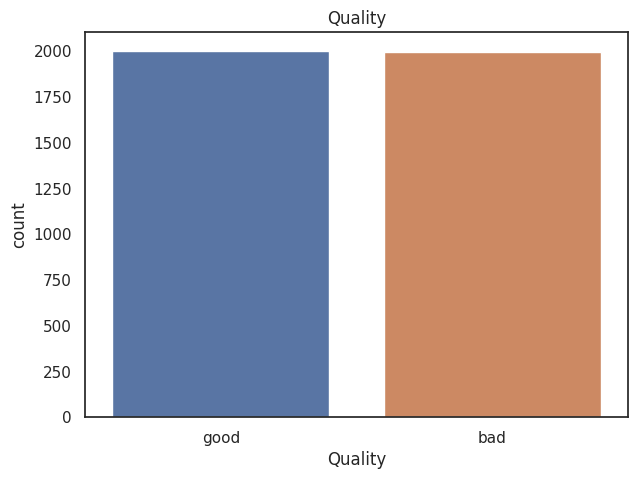

In [104]:
plt.figure(figsize=(7,5))
sb.countplot(data=df,x='Quality')
plt.title('Quality')
plt.show()

In [105]:
df['Quality'].value_counts()

Quality
good    2004
bad     1996
Name: count, dtype: int64

**Relationship between size and other variables**

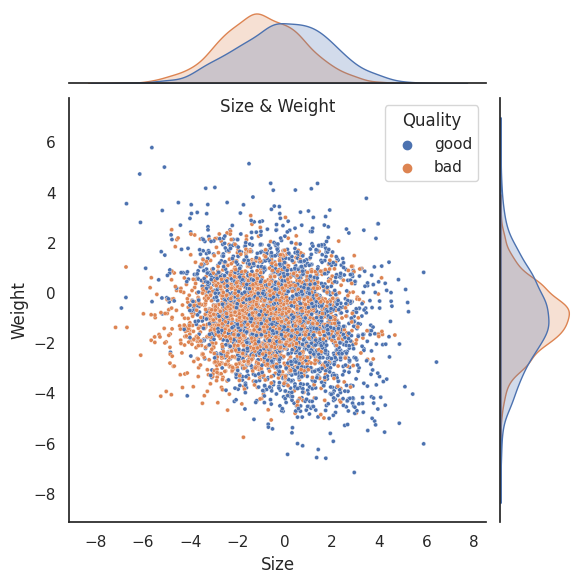

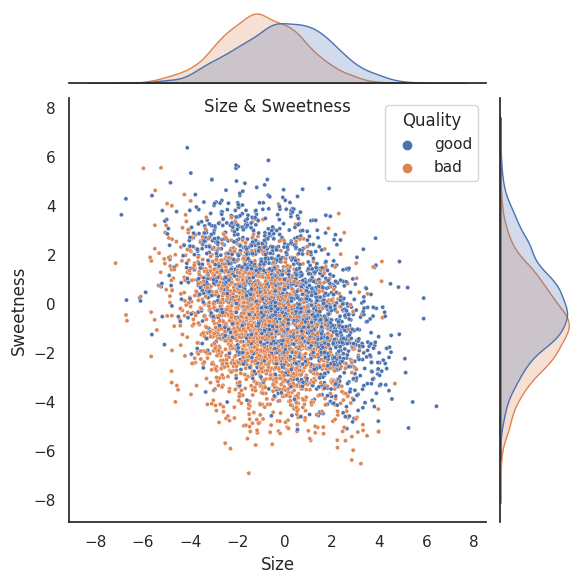

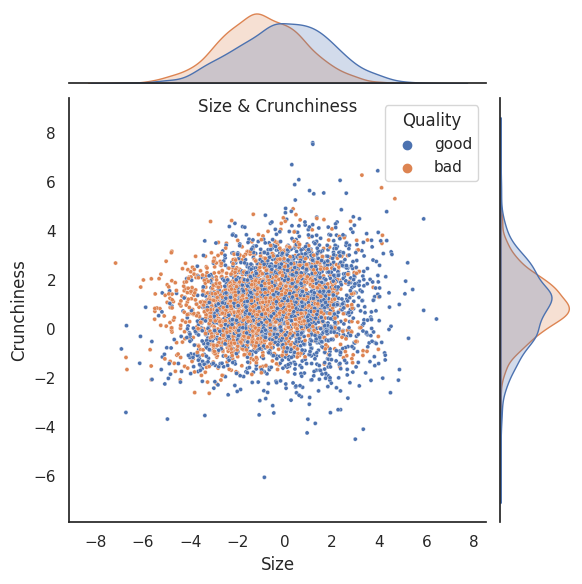

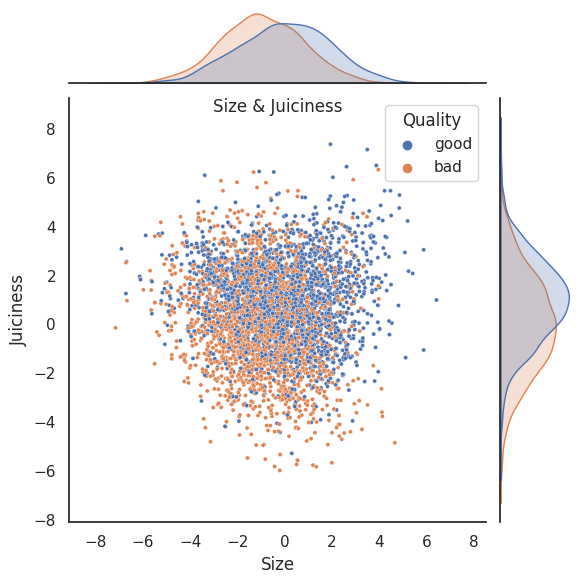

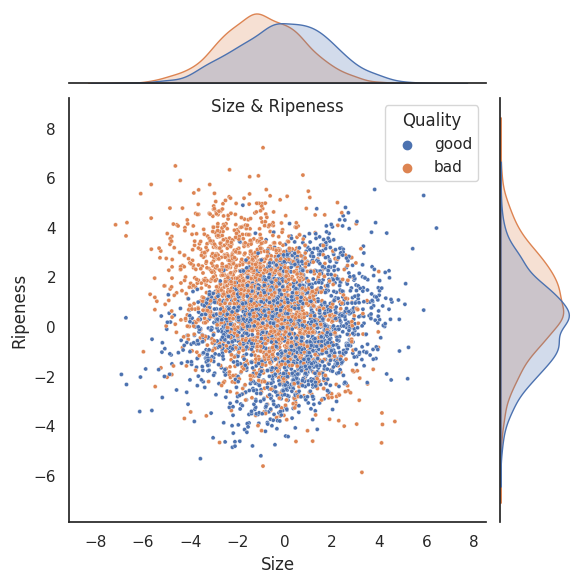

In [106]:
cols = ['Weight','Sweetness','Crunchiness','Juiciness','Ripeness']

for i in cols:
    sb.set(style="white") 
    sb.jointplot(x='Size',y= df[i],hue='Quality',data=df,s=9)
    plt.title(f'Size & {i}', pad = -10)
    plt.show()

**Relationship between Weight and other variables**

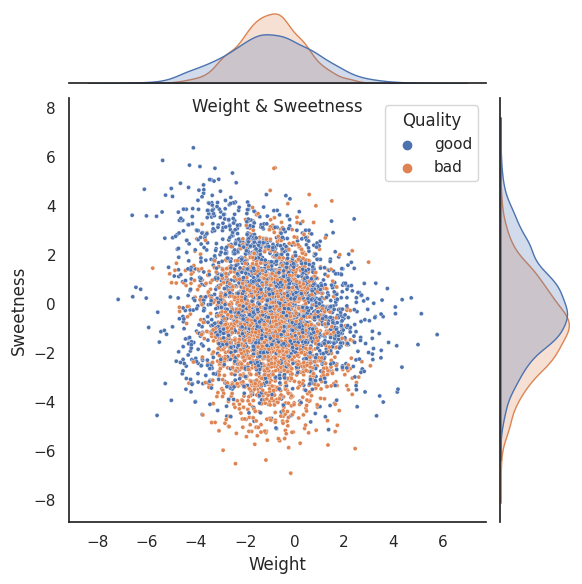

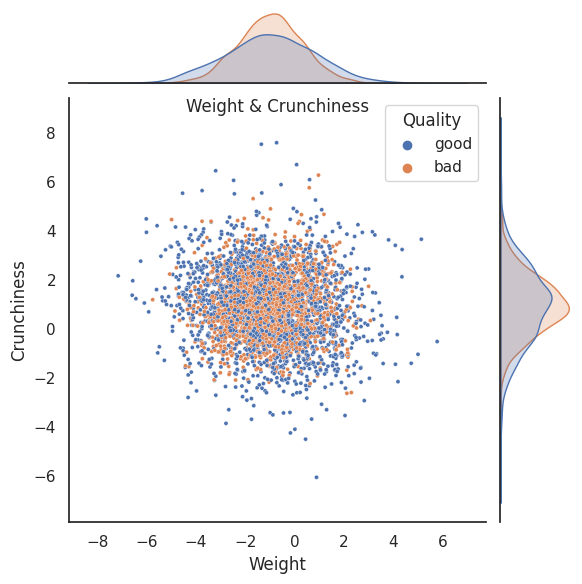

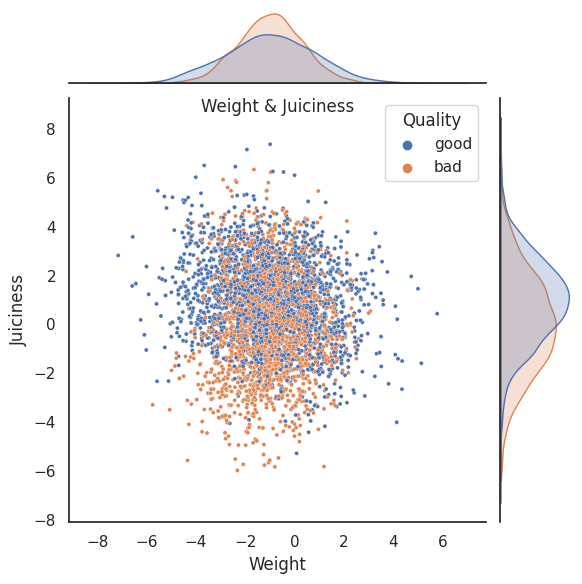

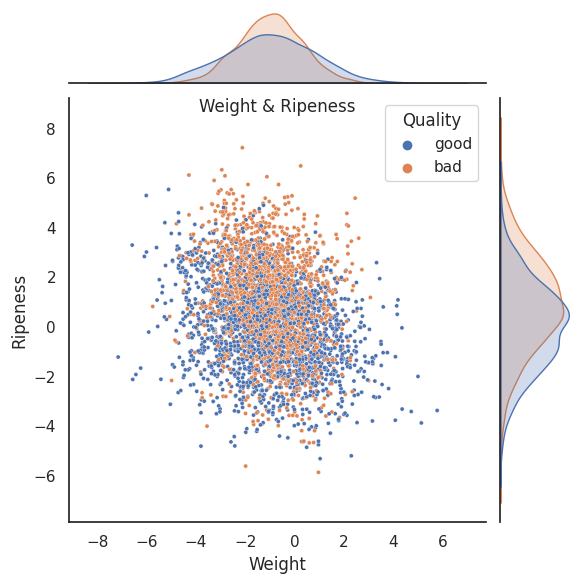

In [107]:
cols = ['Sweetness','Crunchiness','Juiciness','Ripeness']

for i in cols:
    sb.set(style="white") 
    sb.jointplot(x='Weight',y= df[i],hue='Quality',data=df,s=9)
    plt.title(f'Weight & {i}', pad = -10)
    plt.show()

# 1.4 Data Relationship

**Check the correlation**

In [108]:
cor = df_train.corr()
cor

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Label
Size,1.000000,-0.170702,-0.324680,0.169868,-0.018892,-0.134773,0.196218,0.244007
Weight,-0.170702,1.000000,-0.154246,-0.095882,-0.092263,-0.243824,0.016414,0.001421
Sweetness,-0.324680,-0.154246,1.000000,-0.037552,0.095882,-0.273800,0.085999,0.250998
Crunchiness,0.169868,-0.095882,-0.037552,1.000000,-0.259607,-0.201982,0.069943,-0.012376
Juiciness,-0.018892,-0.092263,0.095882,-0.259607,1.000000,-0.097144,0.248714,0.260223
Ripeness,-0.134773,-0.243824,-0.273800,-0.201982,-0.097144,1.000000,-0.202669,-0.264315
Acidity,0.196218,0.016414,0.085999,0.069943,0.248714,-0.202669,1.000000,-0.007697
Label,0.244007,0.001421,0.250998,-0.012376,0.260223,-0.264315,-0.007697,1.000000


<Axes: >

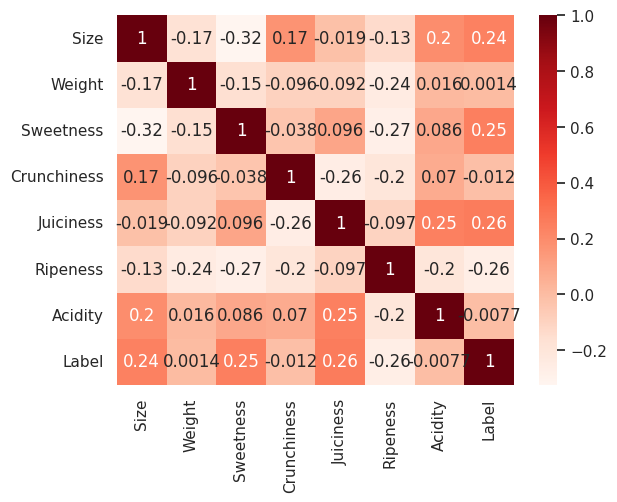

In [109]:
sb.heatmap(df_train.corr(),annot=True,cmap='Reds')

# **2. Modeling**

# 2-1. Import

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 2-2. Modeling

In [111]:
X = df_train[['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 
              'Ripeness', 'Acidity']]
Y = df_train['Label']

X_train, X_test, Y_train,Y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

**RandomForestClassifier**

In [112]:
md_rf = RandomForestClassifier(random_state=42)

In [113]:
md_rf.fit(X_train,Y_train)

RandomForestClassifier(random_state=42)

In [114]:
pred = md_rf.predict(X_test)

In [115]:
confusion_matrix(Y_test,pred)

array([[356,  45],
       [ 38, 361]])

In [116]:
print('accuracy')
accuracy_score(Y_test,pred)

accuracy


0.89625

In [117]:
classification_rep = classification_report(Y_test,pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       401
           1       0.89      0.90      0.90       399

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



**LogisticRegression**

In [118]:
md_lr = LogisticRegression(random_state=42)

In [119]:
md_lr.fit(X_train,Y_train)

LogisticRegression(random_state=42)

In [120]:
pred = md_lr.predict(X_test)

In [121]:
confusion_matrix(Y_test,pred)

array([[303,  98],
       [ 99, 300]])

In [122]:
print('accuracy')
accuracy_score(Y_test,pred)

accuracy


0.75375

In [123]:
classification_rep = classification_report(Y_test,pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.75      0.76      0.75       401
           1       0.75      0.75      0.75       399

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800



**DecisionTree**

In [124]:
md_dt = DecisionTreeClassifier(random_state=42)

In [125]:
md_dt.fit(X_train,Y_train)

DecisionTreeClassifier(random_state=42)

In [126]:
pred = md_dt.predict(X_test)

In [127]:
confusion_matrix(Y_test,pred)

array([[324,  77],
       [ 75, 324]])

In [128]:
print('accuracy')
accuracy_score(Y_test,pred)

accuracy


0.81

In [129]:
classification_rep = classification_report(Y_test,pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       401
           1       0.81      0.81      0.81       399

    accuracy                           0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.81       800



**Among the three models, Random Forest has a high accuracy.** \
**Therefore, Random Forest is best model.**